In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install imutils

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [4]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("/content/drive/MyDrive/brain_dataset/"))
data = []
labels = []

for imagePath in imagePaths:

	label = imagePath.split(os.path.sep)[-2]


	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))


	data.append(image)
	labels.append(label)


data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...


In [5]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20,stratify=labels, random_state=42)

trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [6]:
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 4s 0us/step


In [7]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
INIT_LR = 1e-3
EPOCHS = 25
BS = 8
model = Model(inputs=baseModel.input, outputs=headModel)


for layer in baseModel.layers:
	layer.trainable = False


from tensorflow.keras.optimizers import Adam

# initialize the learning rate, number of epochs, and batch size
INIT_LR = 1e-3
EPOCHS = 25
BS = 32

# compile our model
print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])


[INFO] compiling model...


In [8]:
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...


<ipython-input-8-88f7e153467d>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/25
6/6 [==============================] - 26s 2s/step - loss: 0.6968 - accuracy: 0.6000 - val_loss: 0.6445 - val_accuracy: 0.6078
Epoch 2/25
6/6 [==============================] - 3s 484ms/step - loss: 0.6918 - accuracy: 0.6118 - val_loss: 0.6302 - val_accuracy: 0.6078
Epoch 3/25
6/6 [==============================] - 2s 361ms/step - loss: 0.6632 - accuracy: 0.6176 - val_loss: 0.6192 - val_accuracy: 0.6078
Epoch 4/25
6/6 [==============================] - 2s 355ms/step - loss: 0.6586 - accuracy: 0.6176 - val_loss: 0.6099 - val_accuracy: 0.6078
Epoch 5/25
6/6 [==============================] - 2s 366ms/step - loss: 0.6323 - accuracy: 0.6412 - val_loss: 0.6006 - val_accuracy: 0.6471
Epoch 6/25
6/6 [==============================] - 2s 378ms/step - loss: 0.6203 - accuracy: 0.6765 - val_loss: 0.5907 - val_accuracy: 0.6471
Epoch 7/25
6/6 [==============================] - 4s 605ms/step - loss: 0.5992 - accuracy: 0.6824 - val_loss: 0.5845 - val_accuracy: 0.7843
Epoch 8/25
6/6 [======

In [9]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[INFO] evaluating network...
2/2 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

          no       0.73      0.80      0.76        20
         yes       0.86      0.81      0.83        31

    accuracy                           0.80        51
   macro avg       0.79      0.80      0.80        51
weighted avg       0.81      0.80      0.81        51

[[16  4]
 [ 6 25]]
acc: 0.8039
sensitivity: 0.8000
specificity: 0.8065


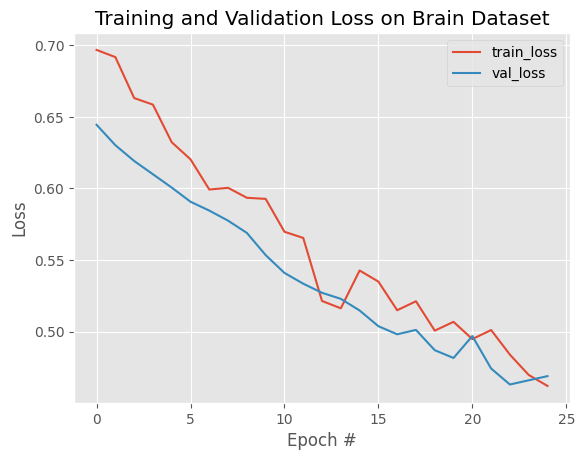

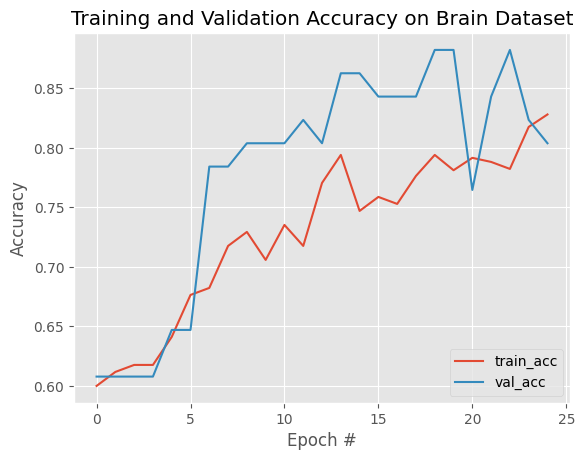

In [10]:
import matplotlib.pyplot as plt
import numpy as np

N = EPOCHS

plt.style.use("ggplot")

# Plot loss
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss on Brain Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.savefig("loss_plot.jpg")

# Plot accuracy
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training and Validation Accuracy on Brain Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.savefig("accuracy_plot.jpg")


In [11]:
print("[INFO] saving Brain Tumor detector model...")
model.save("brain.model", save_format="h5")

[INFO] saving Brain Tumor detector model...
